In [1]:
import yfinance as yf
import pandas as pd
from datetime import date

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.randn()

-3.084994596310445

In [3]:
today = date.today()

data_tesla = yf.download('TSLA', period='1y', interval='1h')
data_google = yf.download('GOOGL', period='1y', interval='1h')
data_meta = yf.download('META', period='1y', interval='1h')
data_amazon = yf.download('AMZN', period='1y', interval='1h')
data_nvidia = yf.download('NVDA', period='1y', interval='1h')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data_tesla.to_csv("./Data/tesla.csv")
data_google.to_csv("./Data/google.csv")
data_meta.to_csv("./Data/meta.csv")
data_amazon.to_csv("./Data/amazon.csv")
data_nvidia.to_csv("./Data/nvidia.csv")

In [5]:
data_tesla.index

DatetimeIndex(['2023-09-05 09:30:00-04:00', '2023-09-05 10:30:00-04:00',
               '2023-09-05 11:30:00-04:00', '2023-09-05 12:30:00-04:00',
               '2023-09-05 13:30:00-04:00', '2023-09-05 14:30:00-04:00',
               '2023-09-05 15:30:00-04:00', '2023-09-06 09:30:00-04:00',
               '2023-09-06 10:30:00-04:00', '2023-09-06 11:30:00-04:00',
               ...
               '2024-09-03 13:30:00-04:00', '2024-09-03 14:30:00-04:00',
               '2024-09-03 15:30:00-04:00', '2024-09-04 09:30:00-04:00',
               '2024-09-04 10:30:00-04:00', '2024-09-04 11:30:00-04:00',
               '2024-09-04 12:30:00-04:00', '2024-09-04 13:30:00-04:00',
               '2024-09-04 14:30:00-04:00', '2024-09-04 15:30:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Datetime', length=1756, freq=None)

In [7]:
def calc_up_down(data):
    data['Return'] = data['Close'].pct_change()
    data['Direction'] = data['Return'].apply(lambda x: 1 if x > 0 else 0)

    data = data.dropna()

    X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    y = data['Direction']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    next_hour_direction = model.predict([X.iloc[-1]])[0]
    direction_str = 'Up' if next_hour_direction == 1 else 'Down'
    print(X_train.shape)
    print(f'Predicted direction for the next hour: {direction_str}')

    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f'Model accuracy: {accuracy * 100:.2f}%')
   
    return model, predictions

In [8]:
tesla_up_down, tesla_pred = calc_up_down(data_tesla)
google_up_down, google_pred = calc_up_down(data_google)
nvidia_up_down, nvida_pred = calc_up_down(data_nvidia)
amazon_up_down, amazon_pred = calc_up_down(data_amazon)
meta_up_down, meta_pred = calc_up_down(data_meta)

(1404, 5)
Predicted direction for the next hour: Up
Model accuracy: 77.49%
(1404, 5)
Predicted direction for the next hour: Down
Model accuracy: 70.94%
(1404, 5)
Predicted direction for the next hour: Up
Model accuracy: 71.23%
(1404, 5)
Predicted direction for the next hour: Up
Model accuracy: 72.93%
(1404, 5)
Predicted direction for the next hour: Down
Model accuracy: 72.36%


In [31]:
{
    "tesla":[data_tesla,tesla_up_down]
}

{'tesla': [                                 Open        High         Low       Close  \
  Datetime                                                                    
  2023-09-05 09:30:00-04:00  245.000000  253.720001  244.860001  252.149994   
  2023-09-05 10:30:00-04:00  252.149307  253.990005  251.080002  252.289993   
  2023-09-05 11:30:00-04:00  252.274902  255.809998  252.091995  255.514404   
  2023-09-05 12:30:00-04:00  255.550003  256.899994  255.139999  255.360001   
  2023-09-05 13:30:00-04:00  255.350006  257.500000  255.100006  257.321594   
  ...                               ...         ...         ...         ...   
  2024-09-04 09:30:00-04:00  210.759995  219.490005  210.619995  219.414993   
  2024-09-04 10:30:00-04:00  219.380096  221.330002  218.759995  219.809998   
  2024-09-04 11:30:00-04:00  219.815002  220.839996  218.516006  220.740005   
  2024-09-04 12:30:00-04:00  220.720093  222.220001  220.720093  220.955002   
  2024-09-04 13:30:00-04:00  220.910004  22

In [32]:
with open("tesla_up_down.pkl","wb") as f:
    pickle.dump(tesla_up_down,f)
with open("google_up_down.pkl","wb") as f:
    pickle.dump(google_up_down,f)
with open("nvidia_up_down.pkl","wb") as f:
    pickle.dump(nvidia_up_down,f)
with open("amazon_up_down.pkl","wb") as f:
    pickle.dump(amazon_up_down,f)
with open("meta_up_down.pkl","wb") as f:
    pickle.dump(meta_up_down,f)

In [33]:
def preprocess_for_forecasting(data):
    close_prices = data['Close'].values
    close_prices = close_prices.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)
    
    look_back = 60

    X, y = [], []
    for i in range(look_back, len(scaled_data)):
        X.append(scaled_data[i-look_back:i, 0])
        y.append(scaled_data[i, 0])
        
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")
    
    return X,y

def forecasting_model(data):
    X,y = preprocess_for_forecasting(data)
    
    model = Sequential()
    
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=10, batch_size=32)
    
    return model

In [34]:
tesla_LSTM = forecasting_model(data_tesla)
google_LSTM = forecasting_model(data_google)
nvidia_LSTM = forecasting_model(data_nvidia)
amazon_LSTM = forecasting_model(data_amazon)
meta_LSTM = forecasting_model(data_meta)

Shape of X: (1694, 60, 1), Shape of y: (1694,)
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0903
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0053
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0049
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0043
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0043
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.0039
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0038
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0031
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0030
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0031
Shape of X: (1694, 60, 1), Shape of y: (1694,)
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 0.0392
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0033
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0034
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/

In [38]:
with open("tesla_LSTM.pkl","wb") as f:
    pickle.dump(tesla_LSTM,f)
with open("google_LSTM.pkl","wb") as f:
    pickle.dump(google_LSTM,f)
with open("nvidia_LSTM.pkl","wb") as f:
    pickle.dump(nvidia_LSTM,f)
with open("amazon_LSTM.pkl","wb") as f:
    pickle.dump(amazon_LSTM,f)
with open("meta_LSTM.pkl","wb") as f:
    pickle.dump(meta_LSTM,f)

In [40]:
predictions = []

# Start with the last 'look_back' days of data
look_back = 60
last_look_back = scaled_data[-look_back:]
current_input = last_look_back

for _ in range(24):
    current_input = np.reshape(current_input, (1, look_back, 1))
    next_predicted_price_scaled = model.predict(current_input)
    next_predicted_price = scaler.inverse_transform(next_predicted_price_scaled)
    predictions.append(next_predicted_price[0][0])

    # Update the input sequence to include the latest prediction and remove the oldest one
    next_value_scaled = next_predicted_price_scaled[0]
    current_input = np.append(current_input[0][1:], next_value_scaled)
    current_input = np.reshape(current_input, (1, look_back, 1))

# Display the predicted prices for the next 24 hours
for i, price in enumerate(predictions):
    print(f'Predicted price in {i+1} hours: {price:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted price in 1 hours: 213.43
Predicted price in 2 hours: 213.41
Predicted price in

In [41]:
predictions

[213.42966,
 213.40991,
 213.39586,
 213.38744,
 213.38353,
 213.38275,
 213.3839,
 213.38602,
 213.3883,
 213.3903,
 213.39166,
 213.39227,
 213.39201,
 213.39088,
 213.38892,
 213.3862,
 213.3828,
 213.37874,
 213.37416,
 213.3691,
 213.36366,
 213.35786,
 213.35179,
 213.34546]

C:\Users\Asus\AppData\Local\Temp\ipykernel_20732\1424364726.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_range = pd.date_range(start=data.index[-1], periods=25, freq='H')[1:]


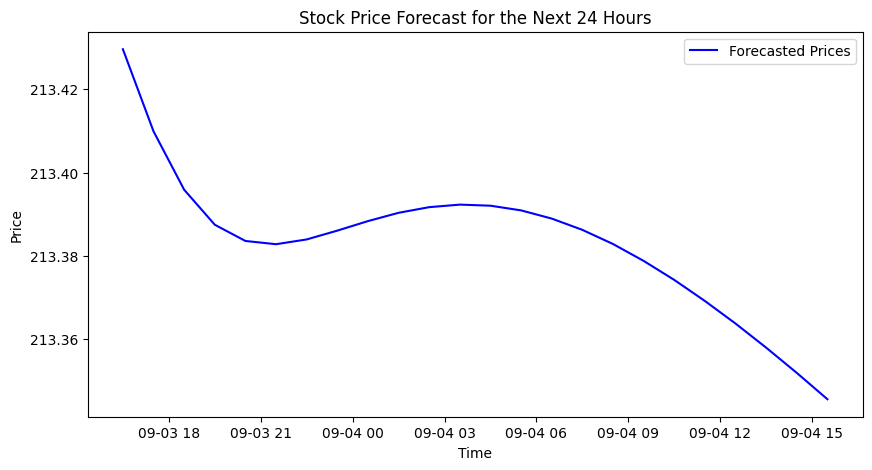

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a time range for the next 24 hours
time_range = pd.date_range(start=data.index[-1], periods=25, freq='H')[1:]

# Plot the forecasted prices
plt.figure(figsize=(10, 5))
plt.plot(time_range, predictions, color='blue', label='Forecasted Prices')
plt.title('Stock Price Forecast for the Next 24 Hours')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()